# 4. Transformer recipe generator training

Note: This notebook is desinged to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the recipe dataset.



In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.8 MB/s eta 0:00:00


Import modules and set random seeds.

In [2]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [3]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

Vocabulary size: 30522


Download the recipe dataset and extract directions texts.

In [4]:
from datasets import load_dataset
recipe = load_dataset('Shengtao/recipe')

def join_title_and_directions(title_directions):
    title, directions = title_directions
    return 'Recipe for {}: {}'.format(title, directions)

recipe_texts = list(map(join_title_and_directions,
                        zip(recipe['train']['title'], recipe['train']['directions'])))
recipe_texts = recipe_texts[::4] # Select 25% of the entire training set.

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/Shengtao___csv/Shengtao--recipe-3a76906d12322926/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Check the distribuion of the text length.

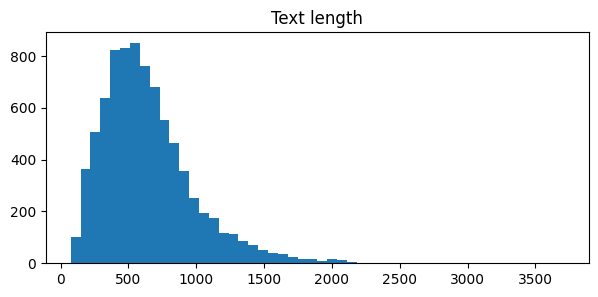

In [5]:
fig = plt.figure(figsize=(7, 3))
subplot = fig.add_subplot(1,1,1)
subplot.set_title('Text length')
_ = subplot.hist(list(map(lambda x: len(x), recipe_texts)), bins=50)

Create the training and test datasets, truncating long texts into 512 words.

In [6]:
MAX_LEN = 512

train_text, test_text = train_test_split(recipe_texts, test_size=0.1)
train_set = tokenizer(train_text, max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])[:,:-1]
train_label = np.array(train_set['input_ids'])[:,1:]

test_set = tokenizer(test_text, max_length=MAX_LEN,
                      padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])[:,:-1]
test_label = np.array(test_set['input_ids'])[:,1:]

Define the positional embedding layer.

In [7]:
class Embeddings(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(Embeddings, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=max_len,
                                        output_dim=embed_dim)
        self.dropout = layers.Dropout(rate=0.5)
        self.ln = layers.LayerNormalization(epsilon=1e-12)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        position_ids = tf.range(start=0, limit=seq_len, delta=1)
        position_embeddings = self.pos_emb(position_ids)

        token_embeddings = self.token_emb(inputs)
        embeddings = token_embeddings + position_embeddings # Add positional embeddings

        embeddings = self.ln(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

Dfiner the Transformer encoder block.

In [8]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim):
        super(TransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(rate=0.1)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation='relu')
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(rate=0.1)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        causal_mask = self.causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        attention_output =  attention_output + inputs # Skip connection
        attention_output = self.ln_1(attention_output)

        ffn_1 = self.ffn_1(attention_output)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)

        ffn_output = ffn_output + attention_output # Skip connection
        ffn_output = self.ln_2(ffn_output)
        return (ffn_output, attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
            }
        )
        return config

Define the Transformer model consisted of a single Transformer encoder blocks.

In [9]:
EMBEDDING_DIM = 512
N_HEADS = 8
KEY_DIM = EMBEDDING_DIM // N_HEADS
FEED_FORWARD_DIM = 2048

text_inputs = layers.Input(shape=(None,), dtype=tf.int32)

x = Embeddings(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(text_inputs)
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM)(x)
output = layers.Dense(VOCAB_SIZE, activation='softmax')(x)

# Model for training and prediction
transformer_model = models.Model(
    inputs=text_inputs, outputs=output)

# Model for inference including attention scores
attention_scores_model = models.Model(
    inputs=text_inputs,
    outputs=[output, attention_scores])

transformer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embeddings (Embeddings)     (None, None, 512)         15890432  
                                                                 
 transformer_block (Transfor  ((None, None, 512),      3152384   
 merBlock)                    (None, 8, None, None))             
                                                                 
 dense_2 (Dense)             (None, None, 30522)       15657786  
                                                                 
Total params: 34,700,602
Trainable params: 34,700,602
Non-trainable params: 0
_________________________________________________________________


Compile the model using the Adam optimizer, and the sparse categorical crossentroy as a loss function.

In [10]:
transformer_model.compile('adam',
                          loss=losses.SparseCategoricalCrossentropy(),
                          metrics=['acc'])

Train the model.

In [11]:
%%time
history = transformer_model.fit(train_text, train_label,
                                validation_data=(test_text, test_label),
                                batch_size=8, epochs=5)

Epoch 1/5
921/921 [==============================] - 261s 268ms/step - loss: 1.1083 - acc: 0.7986 - val_loss: 0.8767 - val_acc: 0.8225
Epoch 2/5
921/921 [==============================] - 230s 250ms/step - loss: 0.8253 - acc: 0.8263 - val_loss: 0.7782 - val_acc: 0.8375
Epoch 3/5
921/921 [==============================] - 227s 246ms/step - loss: 0.7433 - acc: 0.8385 - val_loss: 0.7156 - val_acc: 0.8479
Epoch 4/5
921/921 [==============================] - 226s 246ms/step - loss: 0.6871 - acc: 0.8468 - val_loss: 0.6823 - val_acc: 0.8539
Epoch 5/5
921/921 [==============================] - 224s 243ms/step - loss: 0.6495 - acc: 0.8525 - val_loss: 0.6624 - val_acc: 0.8566
CPU times: user 8min 57s, sys: 28.4 s, total: 9min 25s
Wall time: 19min 30s


Mount the google drive and save the trained model.

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

transformer_model.save('/content/gdrive/My Drive/Transformer_recipe_generator')
attention_scores_model.save('/content/gdrive/My Drive/Transformer_recipe_generator_attention_scores')

Mounted at /content/gdrive


In [13]:
!ls -lhR '/content/gdrive/My Drive/Transformer_recipe_generator'
!ls -lhR '/content/gdrive/My Drive/Transformer_recipe_generator_attention_scores'

'/content/gdrive/My Drive/Transformer_recipe_generator':
total 577K
drwx------ 2 root root 4.0K Jul 23 10:14 assets
-rw------- 1 root root   57 Jul 23 10:14 fingerprint.pb
-rw------- 1 root root  22K Jul 23 10:14 keras_metadata.pb
-rw------- 1 root root 547K Jul 23 10:14 saved_model.pb
drwx------ 2 root root 4.0K Jul 23 10:14 variables

'/content/gdrive/My Drive/Transformer_recipe_generator/assets':
total 0

'/content/gdrive/My Drive/Transformer_recipe_generator/variables':
total 398M
-rw------- 1 root root 398M Jul 23 10:14 variables.data-00000-of-00001
-rw------- 1 root root 4.4K Jul 23 10:14 variables.index
'/content/gdrive/My Drive/Transformer_recipe_generator_attention_scores':
total 456K
drwx------ 2 root root 4.0K Jul 23 10:14 assets
-rw------- 1 root root   57 Jul 23 10:14 fingerprint.pb
-rw------- 1 root root  21K Jul 23 10:14 keras_metadata.pb
-rw------- 1 root root 427K Jul 23 10:14 saved_model.pb
drwx------ 2 root root 4.0K Jul 23 10:14 variables

'/content/gdrive/My Drive/